# 1. Algorithme de Deutsch-Jozsa

In [16]:
import numpy as np
from qiskit import *
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram

In [17]:
# set the length of the n-bit input string. 
n = 3

const_oracle = QuantumCircuit(n+1)
output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)
const_oracle.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘

In [18]:
# Balanced Oracle
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()

┌───┐ ░                 ░ ┌───┐
q_0: ┤ X ├─░───■─────────────░─┤ X ├
     └───┘ ░   │             ░ └───┘
q_1: ──────░───┼────■────────░──────
     ┌───┐ ░   │    │        ░ ┌───┐
q_2: ┤ X ├─░───┼────┼────■───░─┤ X ├
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░──────
           ░ └───┘└───┘└───┘ ░

In [19]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_17192\460382824.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle


┌───┐┌───┐ ░                 ░ ┌───┐┌───┐ ░ ┌─┐      
q_0: ┤ H ├┤ X ├─░───■─────────────░─┤ X ├┤ H ├─░─┤M├──────
     ├───┤└───┘ ░   │             ░ ├───┤└───┘ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░───┼────■────────░─┤ H ├──────░──╫─┤M├───
     ├───┤┌───┐ ░   │    │        ░ ├───┤┌───┐ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─┤ X ├┤ H ├─░──╫──╫─┤M├
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘└───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░────────────░──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░            ░  ║  ║  ║ 
c_0: ═════════════════════════════════════════════╩══╬══╬═
                                                     ║  ║ 
c_1: ════════════════════════════════════════════════╩══╬═
                                                        ║ 
c_2: ═══════════════════════════════════════════════════╩═

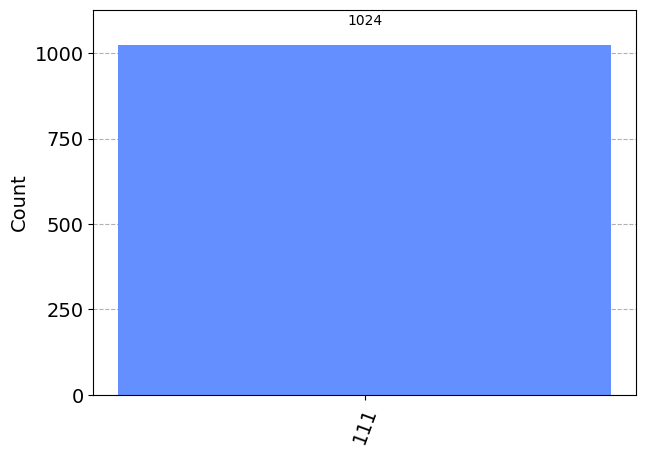

In [20]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [21]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [22]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c_0: ═══════════════════════════╩══╬══╬══╬═
                                   ║  ║  ║ 
c_1: ══════════════════════════════╩══╬══╬═
                                      ║  ║ 
c_2: ═════════════════════════════════╩══╬═
                                         ║ 
c_3: ════════════════════════════════════╩═

### Exemple équilibré

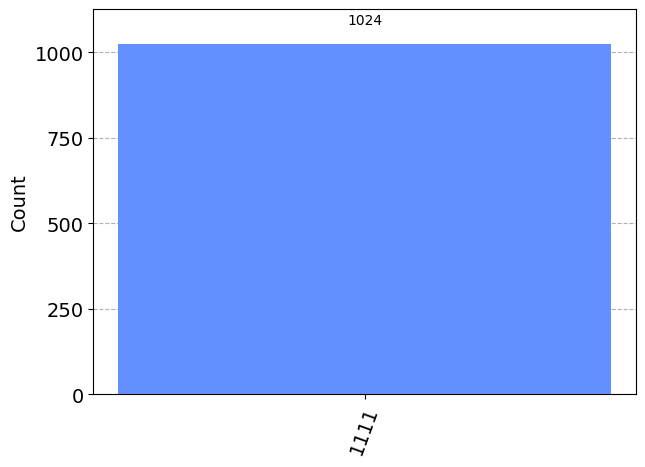

In [23]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

### Exemple constant

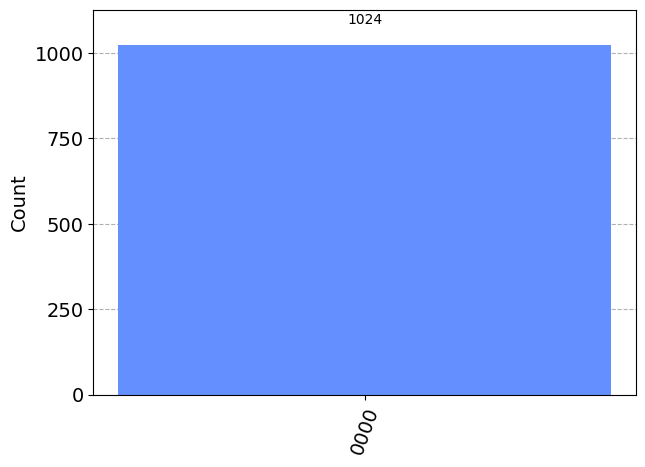

In [24]:
n = 4
oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)

aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

## Commenter dans un rapport les différentes étapes.

### Oracle equilibré
L'oracle fourni par IBM generete un nombre aléatoire de porte X pour toujours simuler la réalité et ne pas avoir toujours les memes états. Il est meme necessaire, car il faut des valeurs differentes pour chaque execution.
Ensuite, on applique des porte X et CNOT qui consitituent l'oracle. Les portes CNOT sont appliqués sur chaque qubit relié au qubit de sortie. Etant encadré par les portes Hadamard, l'état de qubit est restitué à la fin de l'execution de l'oracle.

### Oracle contant

Les opération de l'oracle n'ont aucun effet sur le qubit de sortie, les qubit ne sont meme pas modifiés et donc on a 50% de chance d'avoir 0 ou 1.


# 2. Algorithme de Simon

In [25]:
from qiskit_textbook.tools import simon_oracle

In [26]:
n=3

# entier entre 0 et 2**n
b = np.random.randint(0,2**n)
# (écriture en binaire comme dans l'algorithme pécédent)
b_str = format(b, '0'+str(n)+'b')
b=b_str
n = len(b)
# b_str peut contenir des 0 et des 1 on a alors un comportement deux-un ou n'être écrit qu'avec des 0 -> comportement un-un 


circuit = QuantumCircuit(2*n, n)
#n quibts pour l'entrée plus n qubits pour la sortie

# pour l'entrée de l'oracle on place en état de superposition (H) les n premiers qubits
for i in range(n):
    circuit.h(i)

circuit.barrier()

# placement des CNOT 
circuit += simon_oracle(b) 

circuit.barrier()

# H sur les n premier qubits
for i in range(n):
    circuit.h(i)

# mesure des n premiers qubits
for i in range(n):
    circuit.measure(i,i)
circuit.draw()

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_17192\503581604.py:22: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circuit += simon_oracle(b)


┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■──────────────■────■───░─┤ H ├┤M├──────
     ├───┤ ░   │              │    │   ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────┼────┼───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │  ┌─┴─┐  │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼──┤ X ├──┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  └───┘┌─┴─┐ ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼───────┤ X ├─░───────╫──╫──╫─
           ░      └───┘┌─┴─┐     └───┘ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├───────────░───────╫──╫──╫─
           ░           └───┘           ░       ║  ║  ║ 
c_0: ══════════════════════════════════════════╩══╬══╬═
                                                  ║  ║ 
c_1: ═════════════════════════════════════════════╩══╬═
                                                     ║ 
c_2: ════════════════════════════════════════════════╩═

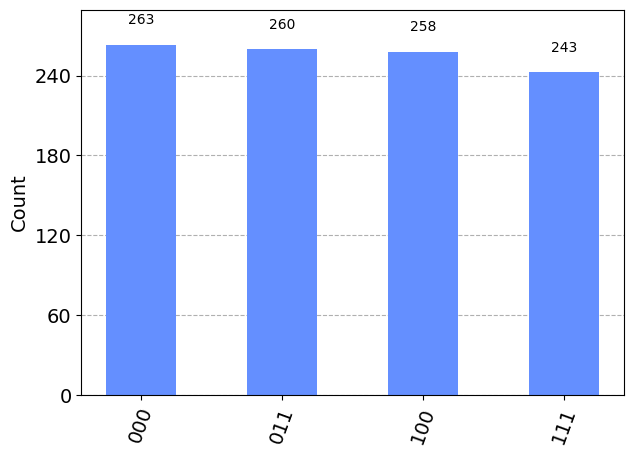

In [27]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(circuit, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [28]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

011.011 = 0 (mod 2)
011.100 = 0 (mod 2)
011.111 = 0 (mod 2)
011.000 = 0 (mod 2)


## Commentaire 

Cet algorithme est très similaire a celui de Deutsch Josza, il sert surtout a démontrer l'utilité des algorithmes quantiques face aux algorithmes classique. Le problème est toujours le meme néanmoins : Identifier s'il y a une sortie pour chaque entré ou s'il y une sortie pour une seule entrée.
La résolution du problème en quantique prend tout son sens lorsqu'on compare le temps d'execution. Dans les deux cas, la complexité temporelle est exponentielle mais la subtilité est que c'est exponentiellement court pour l'execution quantique.
Cela est permis par la caractéristique de superposition des états quantiques, par le biais de la porte Hadamard. Il n'y a alors qu'à exécuter une mesure unique. 